In [49]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from pandas_datareader import data as pdr
from datetime import datetime, timedelta
import data_util  
yf.pdr_override()
from sklearn.svm import SVC

sns.set(rc={'figure.figsize':(20, 15)})

temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), width=800))

import warnings
warnings.filterwarnings('ignore')


In [50]:
apple_stocks=data_util.stock_data('AAPL', 4,'Apple')

[*********************100%%**********************]  1 of 1 completed


PREPARING OUR DATASET USING TIME SERIES CROSS - VALIDATION , THE IMAGE ATTACHED BELOW PROVIDES INSIGHT ONTO HOW WE WANT TO IMPLEMENT CROSSVALIDATION TO OUR TIME SERIES DATA.

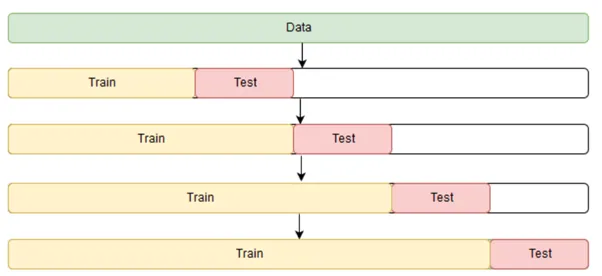

In [51]:
def time_series_cross_validation(df,one_hot_encodings,p):

  # test_percentage = [0.2,0.4,0.6,0.8] #these represent the split between the train and test
    row = int(df.shape[0]*p)
    val_row = int( (df.shape[0]-row)*0.5) + row

    #create the training and validation dataset
    x_train = temp[:row]
    y_train = one_hot_encodings[:row]

    x_val = temp[row:val_row]
    y_val = one_hot_encodings[row:val_row]

    x_test = temp[val_row:]
    y_test = one_hot_encodings[val_row:]

    return x_train,y_train,x_val,y_val,x_test,y_test

def time_series_cross_validation_regression(df,x,y,p):

  # test_percentage = [0.2,0.4,0.6,0.8] #these represent the split between the train and test
    row = int(df.shape[0]*p)
    val_row = int( (df.shape[0]-row)*0.5) + row

    #create the training and validation dataset
    x_train = x[:row]
    y_train = y[:row]

    x_val = x[row:val_row]
    y_val = y[row:val_row]

    x_test = x[val_row:]
    y_test = y[val_row:]

    return x_train,y_train,x_val,y_val,x_test,y_test

**PART 1** - IMPLEMENTING A BASIC CLASSIFYING STRATEGY WHICH TELLS US WHETHER TO BUY OR NOT BUY USING SUPPORT VECTOR CLASSIFIERS

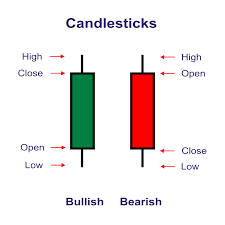

**PART 2** - CREATING THE NECESSARY FEATURES THAT WE REQUIRE

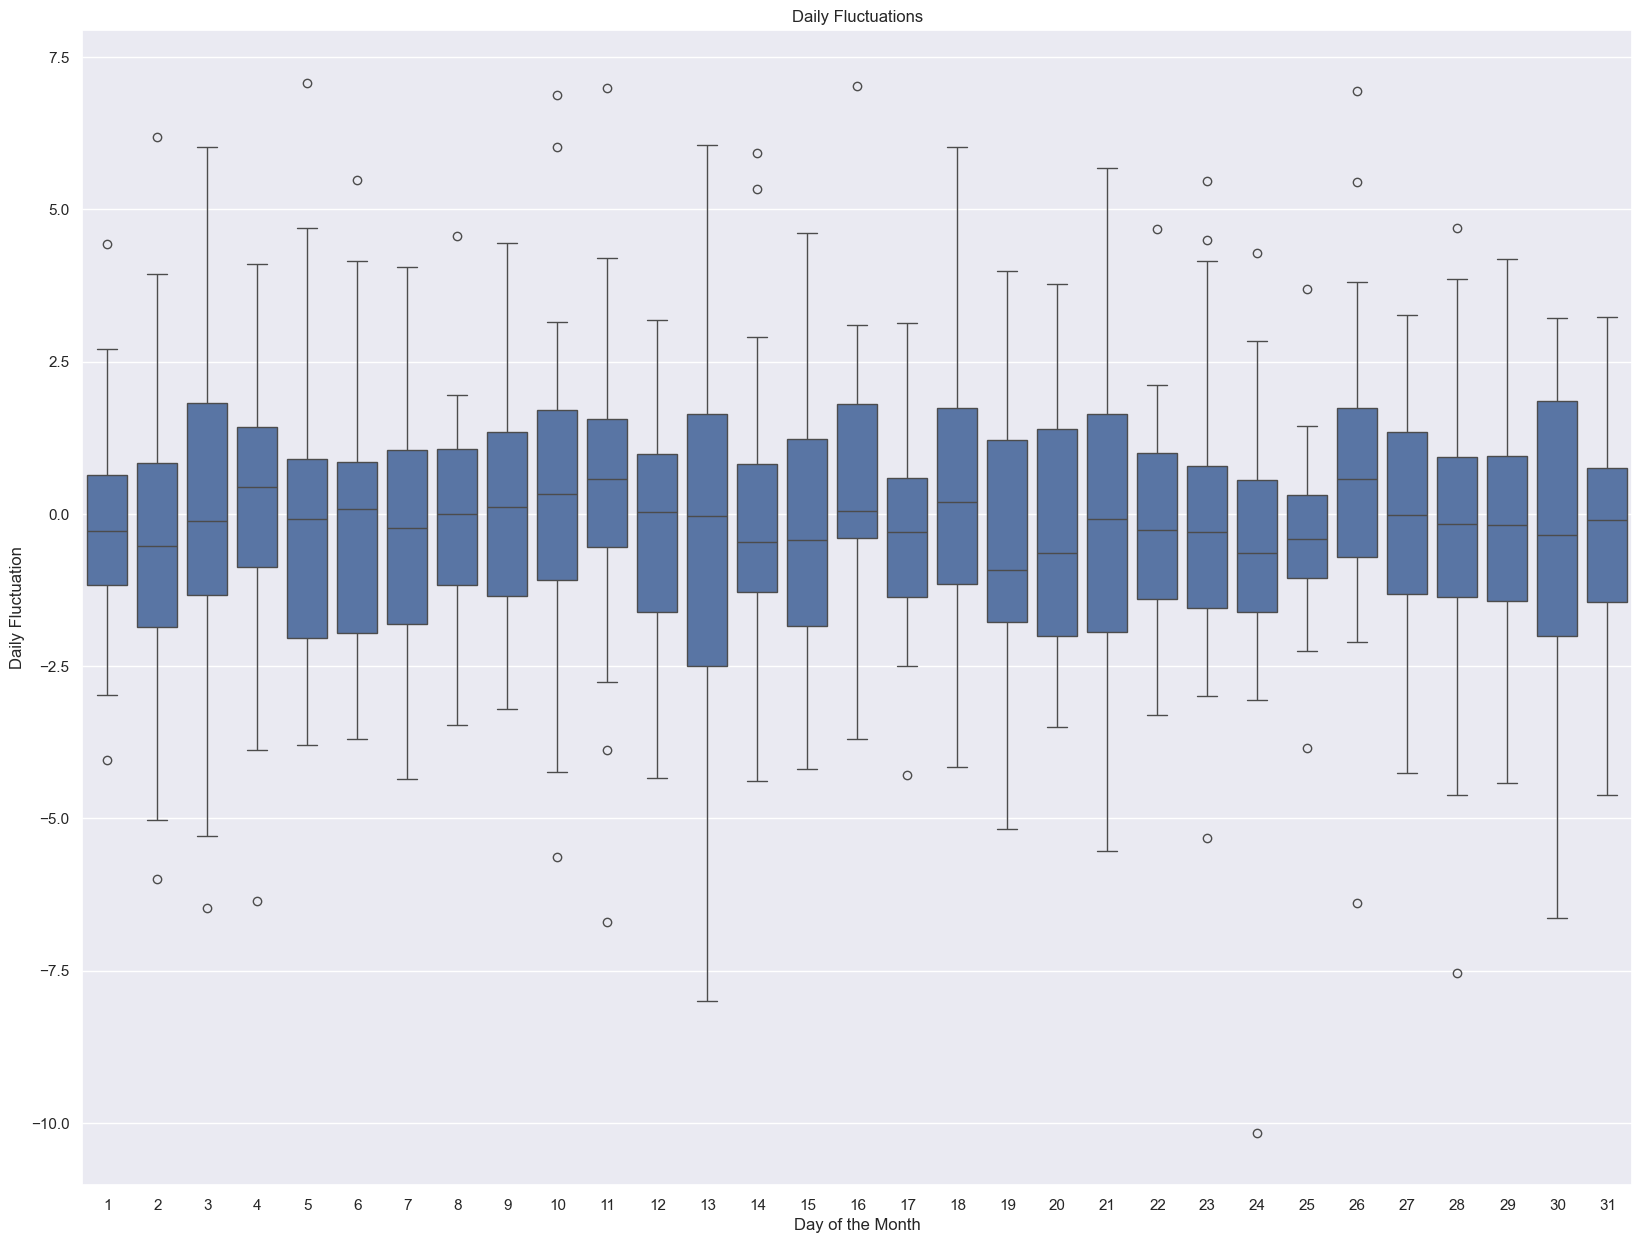

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_features(apple_stocks):

    apple_stocks["Daily-Max-Fluctuation"] = apple_stocks["High"] - apple_stocks["Low"]

    apple_stocks["Daily-Fluctuation"] = apple_stocks["Open"] - apple_stocks["Close"]

    temp = apple_stocks[["Daily-Fluctuation", "Daily-Max-Fluctuation", "Close"]]

    apple_stocks['Day'] = apple_stocks.index.day

    return temp, apple_stocks

def plot_daily_fluctuations(apple_stocks):
    sns.boxplot(data=apple_stocks, x="Day", y="Daily-Fluctuation")
    plt.title('Daily Fluctuations')
    plt.xlabel('Day of the Month')
    plt.ylabel('Daily Fluctuation')
    plt.show()


temp, apple_stocks = create_features(apple_stocks)
plot_daily_fluctuations(apple_stocks)


**Part 3**- Now we prepare our y - labels. Instead of directly using the next day's price in our model , our naive model initially predicts whether it should buy or sell the stock the next day.

In [53]:
buy_or_sell = np.where(apple_stocks.Close.shift(-1) > apple_stocks.Close,1,0)
buy_or_sell

array([0, 1, 0, ..., 1, 0, 0])

**Part 4** - Training a support vector classifier for our 0/1 classification objective

In [54]:
import seaborn as sns

def plot_returns(apple_stocks):
    apple_stocks['return'] = apple_stocks['Close'].pct_change(1)

    # Shift predictions and calculate strategy returns
    apple_stocks['shifted_predictions'] = apple_stocks['predictions'].shift(1)
    apple_stocks['strategy_returns'] = apple_stocks['shifted_predictions'] * apple_stocks['return']

    ret = [0]  # initialize with 0
    strat = [0]
    for i in range(1, len(apple_stocks)):
        ret.append(ret[-1] + apple_stocks['return'].iloc[i])
        strat.append(strat[-1] + apple_stocks['strategy_returns'].iloc[i])
    apple_stocks['ret'] = ret
    apple_stocks['strat'] = strat

    # Plot using seaborn
    sns.lineplot(data=apple_stocks, x=apple_stocks.index, y='ret', color='red', label='Predicted Strategy Returns')
    sns.lineplot(data=apple_stocks, x=apple_stocks.index, y='strat', color='blue', label='Actual Stock Returns')
    plt.title('Returns')
    plt.legend()
    plt.show()



def SVC_Classifier(apple_stocks, x_train, y_train, x_val, y_val, x_test, y_test, X):
    model = SVC()
    model.fit(x_train[["Daily-Fluctuation", "Daily-Max-Fluctuation"]], y_train)

    train_err = model.score(x_train[["Daily-Fluctuation", "Daily-Max-Fluctuation"]], y_train)
    test_err = model.score(x_test[["Daily-Fluctuation", "Daily-Max-Fluctuation"]], y_test)
    val_err = model.score(x_val[["Daily-Fluctuation", "Daily-Max-Fluctuation"]], y_val)

    apple_stocks['predictions'] = model.predict(X[["Daily-Fluctuation", "Daily-Max-Fluctuation"]])

    print("The model's score for the Test Set came out to be : ", test_err)
    print("The model's score for the Validation Set came out to be : ", val_err)
    plot_returns(apple_stocks)

Train - Test Split :  20.0 - 80.0
The model's score for the Test Set came out to be :  0.5062034739454094
The model's score for the Validation Set came out to be :  0.5235732009925558


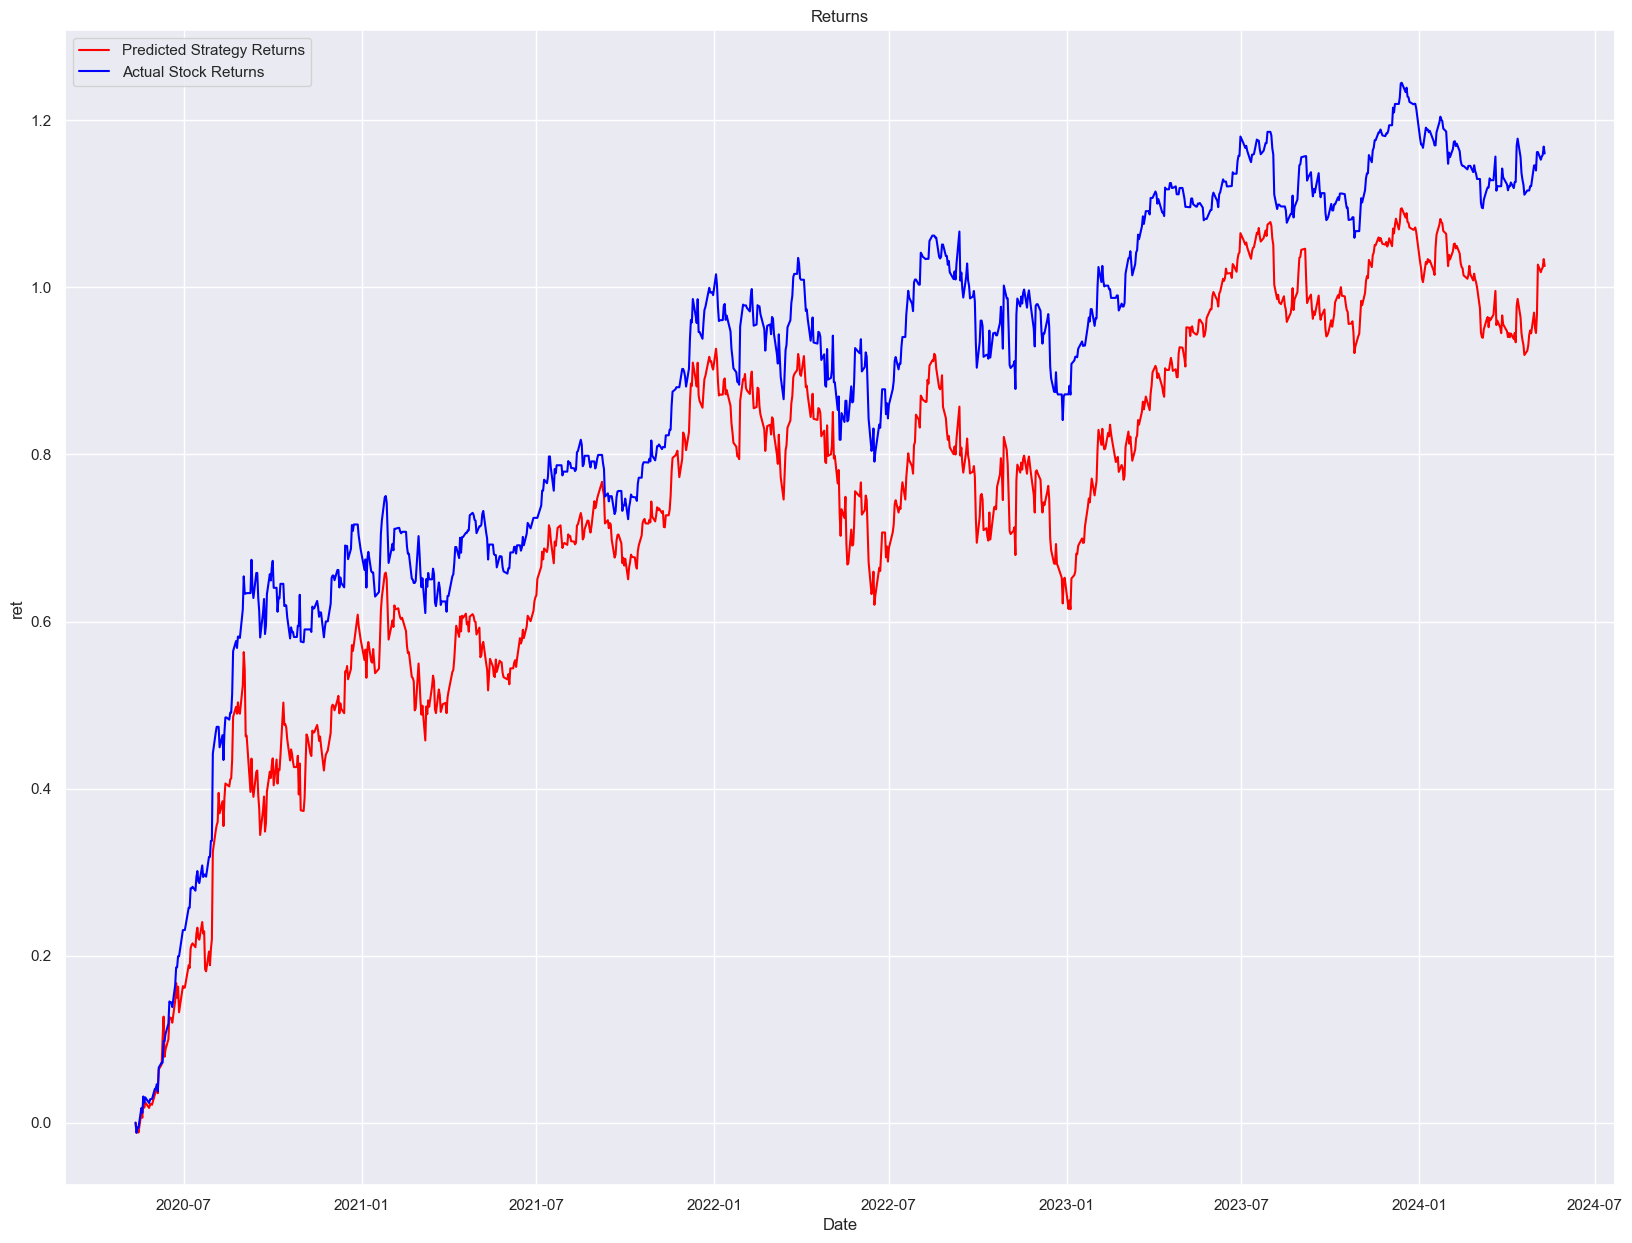

Train - Test Split :  40.0 - 60.0
The model's score for the Test Set came out to be :  0.504950495049505
The model's score for the Validation Set came out to be :  0.4900662251655629


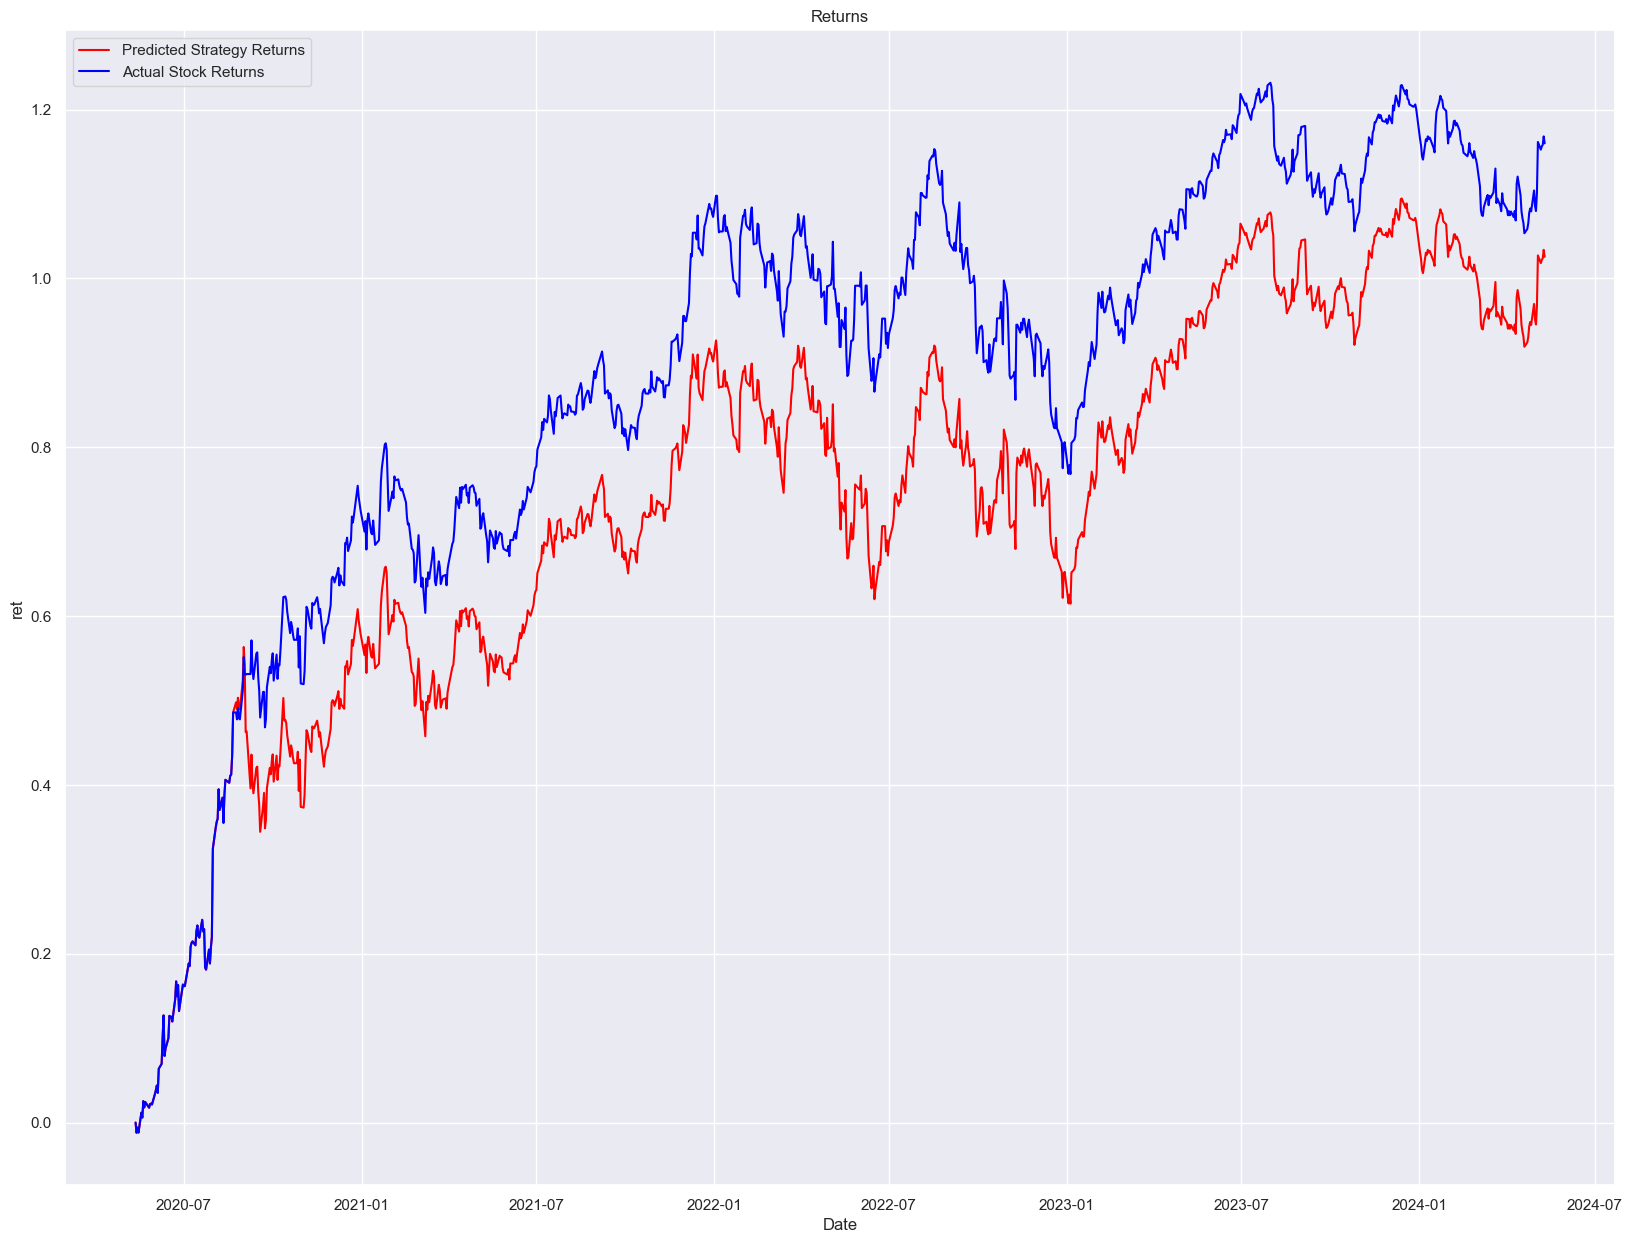

Train - Test Split :  60.0 - 40.0
The model's score for the Test Set came out to be :  0.4752475247524752
The model's score for the Validation Set came out to be :  0.5124378109452736


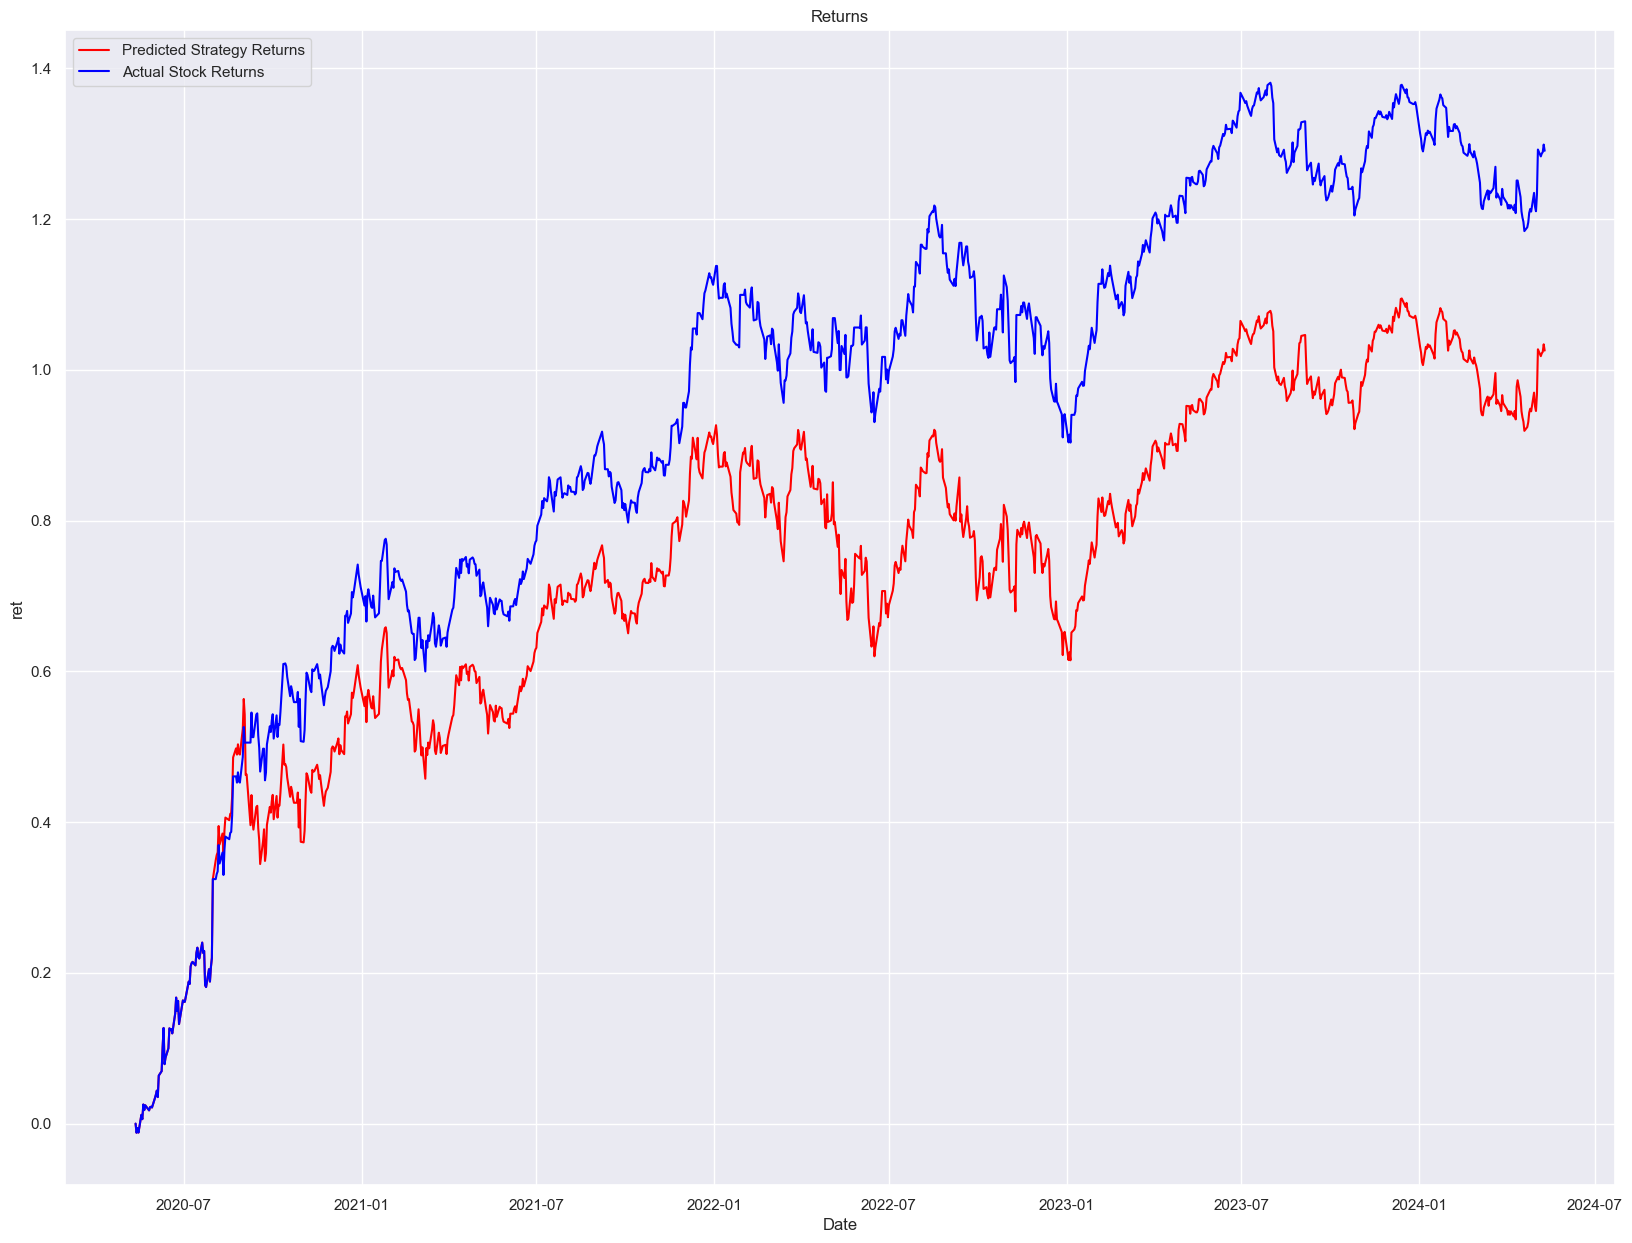

Train - Test Split :  80.0 - 19.999999999999996
The model's score for the Test Set came out to be :  0.38613861386138615
The model's score for the Validation Set came out to be :  0.5544554455445545


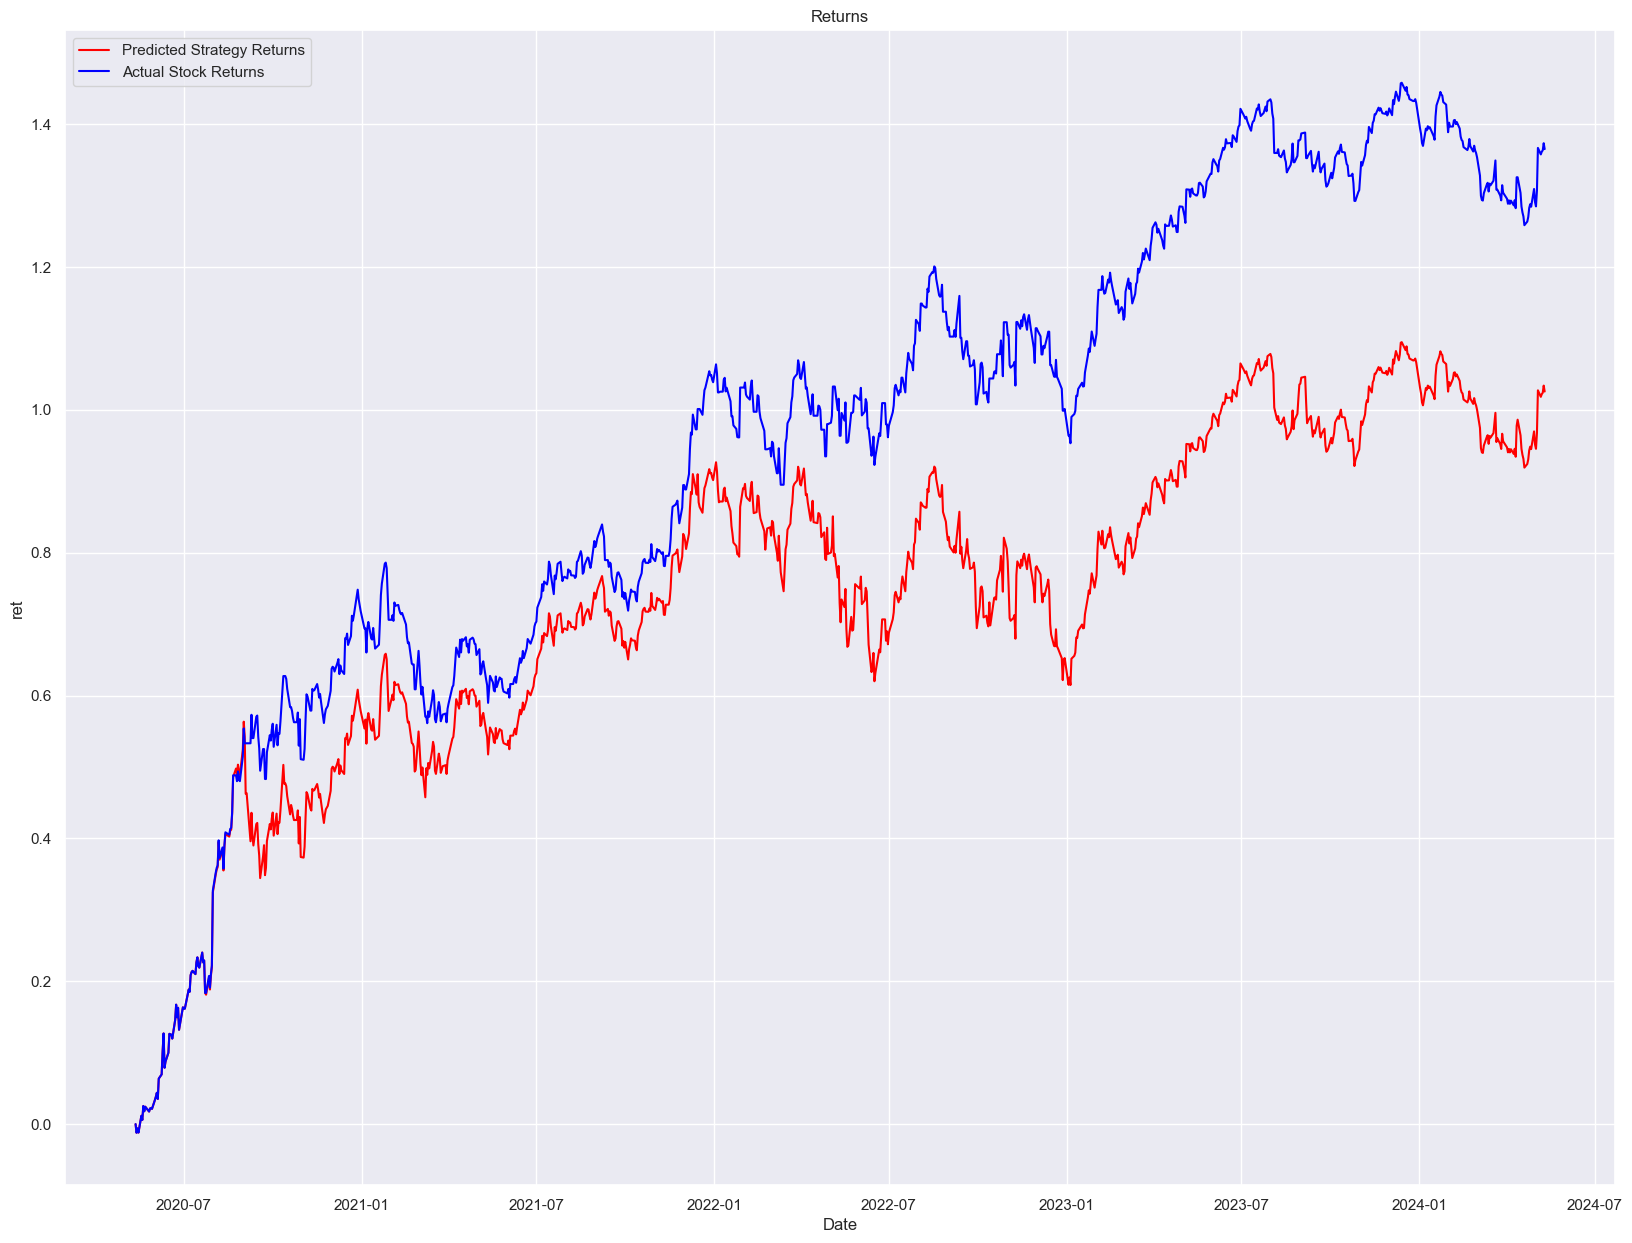

In [55]:
test_percentages = [0.2,0.4,0.6,0.8]

for p in test_percentages:
  print("Train - Test Split : ",(p)*100,"-",(1-p)*100)
  x_train,y_train,x_val,y_val,x_test,y_test = time_series_cross_validation(apple_stocks,buy_or_sell,p)
  SVC_Classifier(apple_stocks,x_train,y_train,x_val,y_val,x_test,y_test,temp)



model-2

In [56]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

regression = LinearRegression()

def Linear_Regression(apple_stocks, x_train, y_train, x_val, y_val, x_test, y_test):
    regression.fit(x_train, y_train)
    test_predictions = regression.predict(x_test)
    val_predictions = regression.predict(x_val)
    test_vs_testpred = pd.DataFrame({'Actual_Price': y_test, 'Predicted_Price': test_predictions})
    val_vs_valpred = pd.DataFrame({'Actual_Price': y_val, 'Predicted_Price': val_predictions})

    print(regression.coef_)

    # Print MSE and summary statistics
    print('MSE for the Test Set:', metrics.mean_squared_error(y_test, test_predictions))
    print("Test Predictions - ")
    print(test_vs_testpred.describe())

    print('MSE for the Val Set:', metrics.mean_squared_error(y_val, val_predictions))
    print("Val Predictions - ")
    print(val_vs_valpred.head(10))

    # Plot actual vs predicted prices
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='Actual_Price', y='Predicted_Price', data=test_vs_testpred)
    plt.title('Test Set: Actual vs Predicted Price')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')

    plt.subplot(1, 2, 2)
    sns.scatterplot(x='Actual_Price', y='Predicted_Price', data=val_vs_valpred)
    plt.title('Validation Set: Actual vs Predicted Price')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming x_train, y_train, x_val, y_val, x_test, y_test are prepared
# Logistic_Regression(apple_stocks, x_train, y_train, x_val, y_val, x_test, y_test)


Train - Test Split :  20.0 - 80.0
[-5.19363695e-01  8.73394540e-01  6.43182369e-01 -1.16197607e-09]
MSE for the Test Set: 0.7763138401649315
Test Predictions - 
       Actual_Price  Predicted_Price
count    403.000000       403.000000
mean     169.382953       169.372160
std       18.497080        18.395113
min      125.019997       125.929095
25%      152.729996       152.277527
50%      173.229996       173.036177
75%      184.040001       183.760399
max      198.110001       197.804438
MSE for the Val Set: 1.1053391982517637
Val Predictions - 
            Actual_Price  Predicted_Price
Date                                     
2021-03-01    127.790001       126.516149
2021-03-02    125.120003       126.230083
2021-03-03    122.059998       123.419545
2021-03-04    120.129997       121.019142
2021-03-05    121.419998       119.322215
2021-03-08    116.360001       117.651754
2021-03-09    121.089996       121.252630
2021-03-10    119.980003       120.412123
2021-03-11    121.959999   

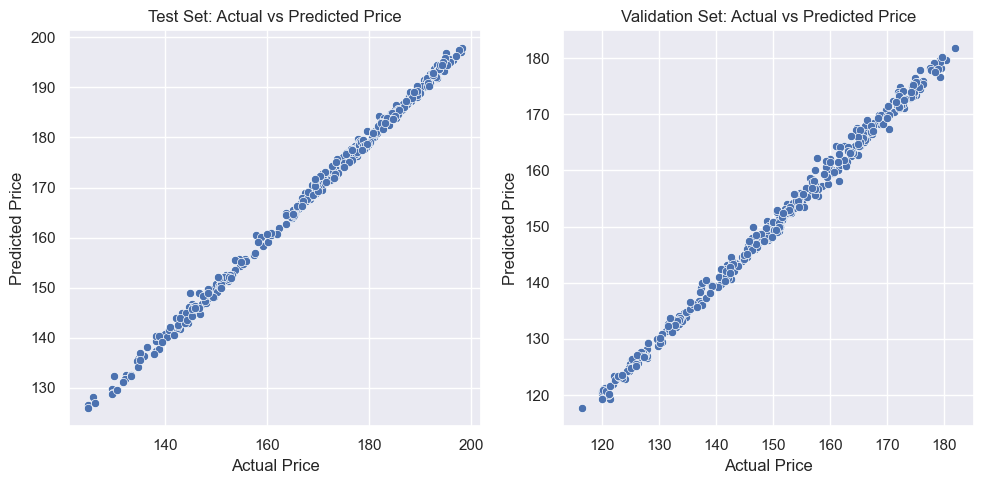

Train - Test Split :  40.0 - 60.0
[-5.85857547e-01  9.07327624e-01  6.74316893e-01 -1.76202941e-09]
MSE for the Test Set: 0.6666696438659969
Test Predictions - 
       Actual_Price  Predicted_Price
count    303.000000       303.000000
mean     178.098383       178.017056
std       11.333246        11.217748
min      145.309998       145.705125
25%      170.750000       171.178438
50%      178.190002       178.150563
75%      187.544998       187.072866
max      198.110001       197.721281
MSE for the Val Set: 1.3498120784544052
Val Predictions - 
            Actual_Price  Predicted_Price
Date                                     
2021-12-14    174.330002       174.931221
2021-12-15    179.300003       176.692212
2021-12-16    172.259995       174.651577
2021-12-17    171.139999       172.375647
2021-12-20    169.750000       169.371350
2021-12-21    172.990005       170.975034
2021-12-22    175.639999       174.562969
2021-12-23    176.279999       175.960736
2021-12-27    180.330002   

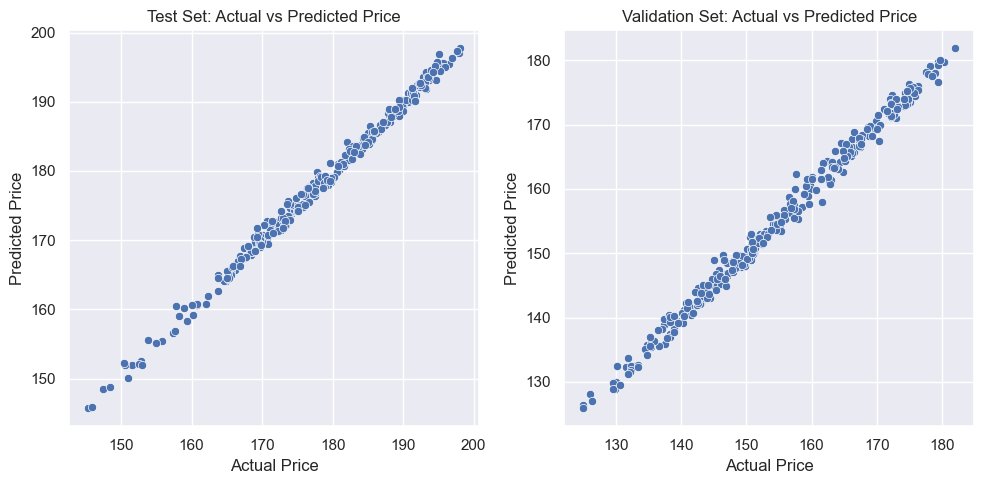

Train - Test Split :  60.0 - 40.0
[-6.96057072e-01  8.86997778e-01  8.07090638e-01  5.36689138e-10]
MSE for the Test Set: 0.6468319187153946
Test Predictions - 
       Actual_Price  Predicted_Price
count    202.000000       202.000000
mean     181.059802       180.952747
std        8.662444         8.514811
min      165.000000       164.501229
25%      173.675003       173.689934
50%      180.450005       180.053862
75%      188.552505       188.629303
max      198.110001       197.716687
MSE for the Val Set: 0.8410246284698908
Val Predictions - 
            Actual_Price  Predicted_Price
Date                                     
2022-10-04    146.100006       145.358337
2022-10-05    146.399994       146.042117
2022-10-06    145.429993       146.750629
2022-10-07    140.089996       140.440968
2022-10-10    140.419998       140.127183
2022-10-11    138.979996       139.728822
2022-10-12    138.339996       139.334680
2022-10-13    142.990005       142.045440
2022-10-14    138.380005   

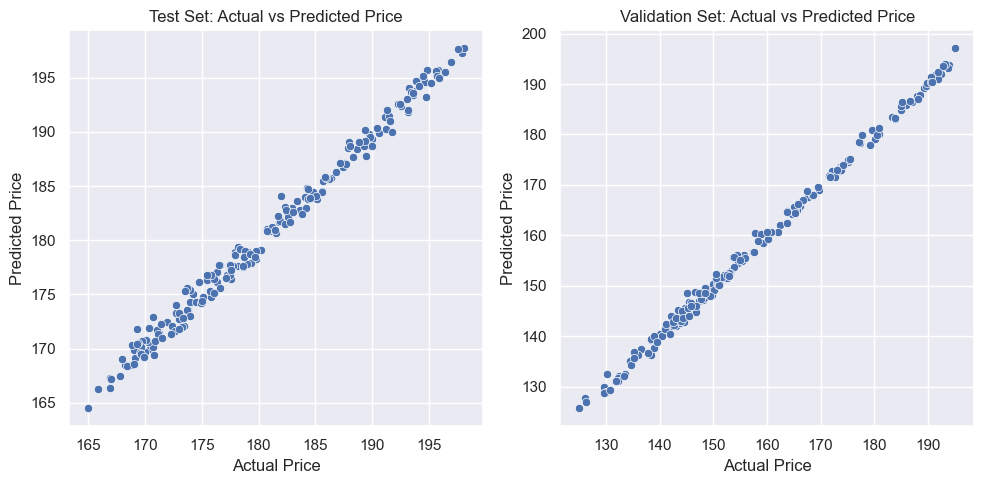

Train - Test Split :  80.0 - 19.999999999999996
[-6.75730581e-01  8.55567828e-01  8.18559034e-01  5.89750471e-10]
MSE for the Test Set: 0.6863454698864774
Test Predictions - 
       Actual_Price  Predicted_Price
count    101.000000       101.000000
mean     180.286633       180.241942
std        9.168627         8.960594
min      165.000000       164.555416
25%      171.130005       171.640459
50%      181.910004       181.778557
75%      186.860001       186.279506
max      197.570007       197.752343
MSE for the Val Set: 0.5803646147138564
Val Predictions - 
            Actual_Price  Predicted_Price
Date                                     
2023-07-25    193.619995       193.808994
2023-07-26    194.500000       194.939367
2023-07-27    193.220001       194.055779
2023-07-28    195.830002       195.782348
2023-07-31    196.449997       195.634503
2023-08-01    195.610001       195.732417
2023-08-02    192.580002       192.418490
2023-08-03    191.169998       191.415987
2023-08-04   

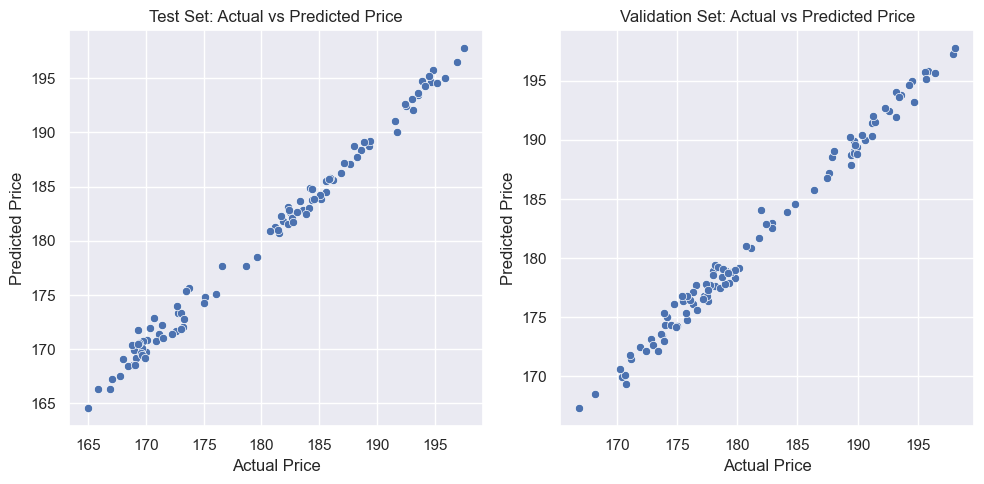

In [57]:
test_percentages = [0.2,0.4,0.6,0.8]

for p in test_percentages:

  print("Train - Test Split : ",(p)*100,"-",(1-p)*100)

  features = apple_stocks[['Open', 'High','Low', 'Volume']]
  labels = apple_stocks['Close']

  x_train,y_train,x_val,y_val,x_test,y_test = time_series_cross_validation_regression(apple_stocks,features,labels,p)

  Linear_Regression(apple_stocks,x_train,y_train,x_val,y_val,x_test,y_test)



FB PROPHET


In [58]:
!pip install prophet


In [59]:
from prophet import Prophet
from prophet.plot import plot_plotly

# Assuming you have already imported necessary libraries and loaded the data

# Reset index of apple_stocks DataFrame
apple_stocks.reset_index(inplace=True)
# apple_stocks.set_index('Date',inplace=True)
apple_stocks_temp = apple_stocks[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

apple_stocks_temp_test = apple_stocks_temp.tail(100)

apple_stocks_temp_train = apple_stocks_temp.head(len(apple_stocks_temp) - 100)

FBprophet = Prophet(daily_seasonality=True)

FBprophet.fit(apple_stocks_temp_train)

future = FBprophet.make_future_dataframe(periods=365)

forecast = FBprophet.predict(future)

fig = plot_plotly(FBprophet, forecast)

fig.add_trace(go.Scatter(x=apple_stocks_temp_test['ds'], y=apple_stocks_temp_test['y'], mode='markers', name='Test Data'))

fig.show()


23:04:18 - cmdstanpy - INFO - Chain [1] start processing
23:04:18 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
forecast['abs_error'] = np.abs(forecast['yhat'] - apple_stocks_temp_test['y'])

# Calculate mean error per day
mean_error_per_day = forecast['abs_error'].mean()

print("Mean error per day:", mean_error_per_day," USD")

Mean error per day: 16.070947043036803  USD


In [61]:
df = apple_stocks
df.drop(['comany_name'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   1007 non-null   datetime64[ns]
 1   Open                   1007 non-null   float64       
 2   High                   1007 non-null   float64       
 3   Low                    1007 non-null   float64       
 4   Close                  1007 non-null   float64       
 5   Adj Close              1007 non-null   float64       
 6   Volume                 1007 non-null   int64         
 7   comany_name            1007 non-null   object        
 8   Daily-Max-Fluctuation  1007 non-null   float64       
 9   Daily-Fluctuation      1007 non-null   float64       
 10  Day                    1007 non-null   int32         
 11  predictions            1007 non-null   int32         
 12  return                 1006 non-null   float64       
 13  shi

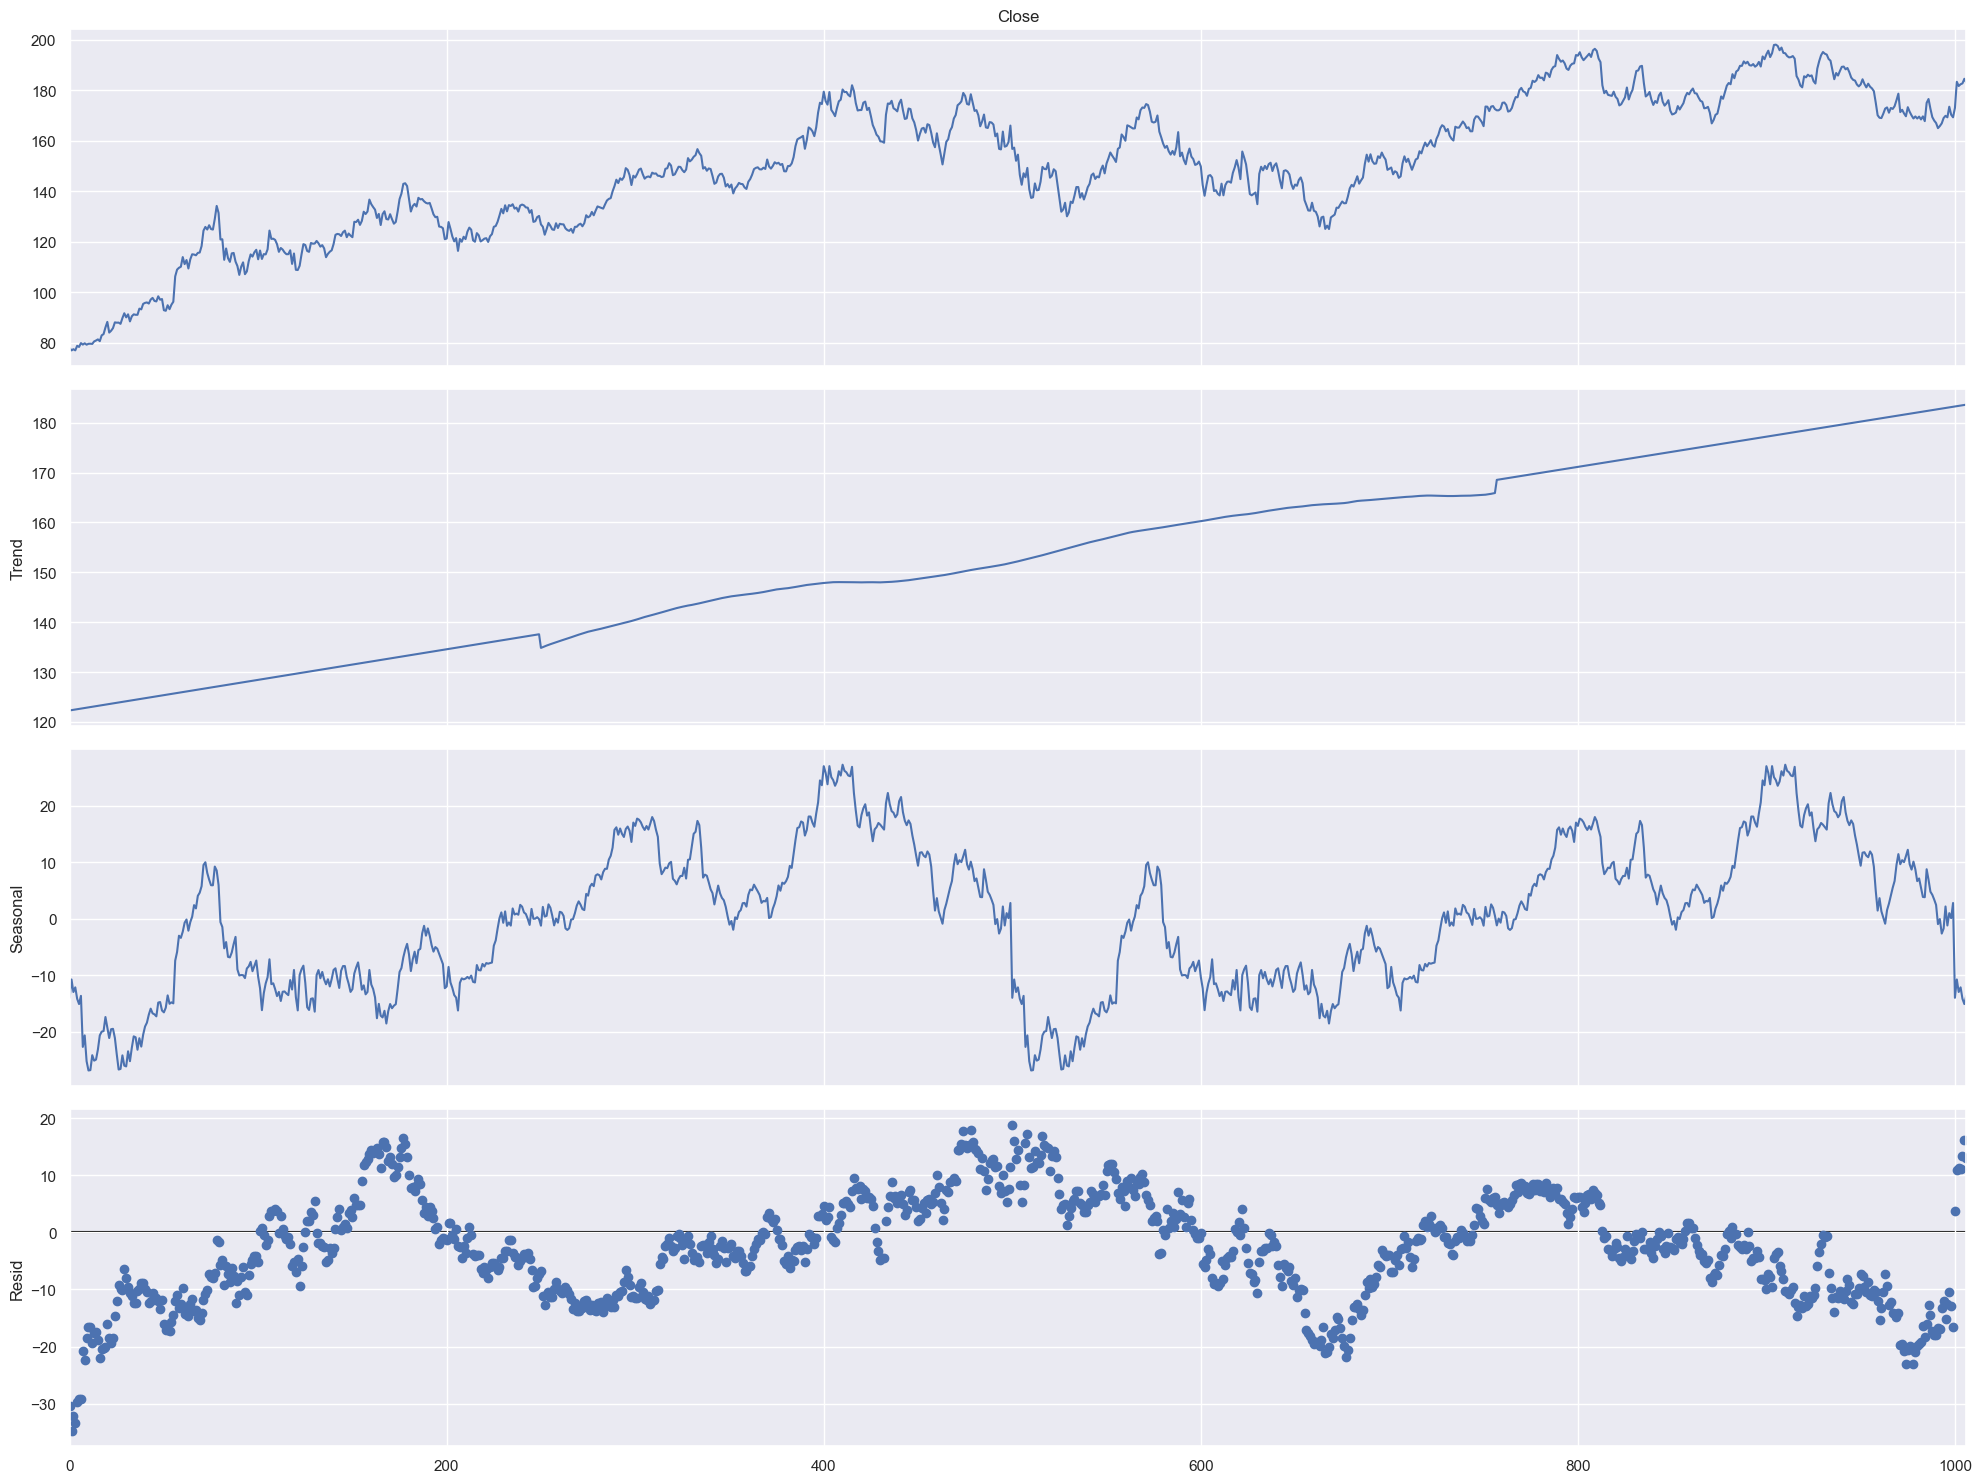

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose
df=apple_stocks
multd = seasonal_decompose(df['Close'],model='additive',extrapolate_trend='freq',period=100*5)
multd.plot()
plt.show()

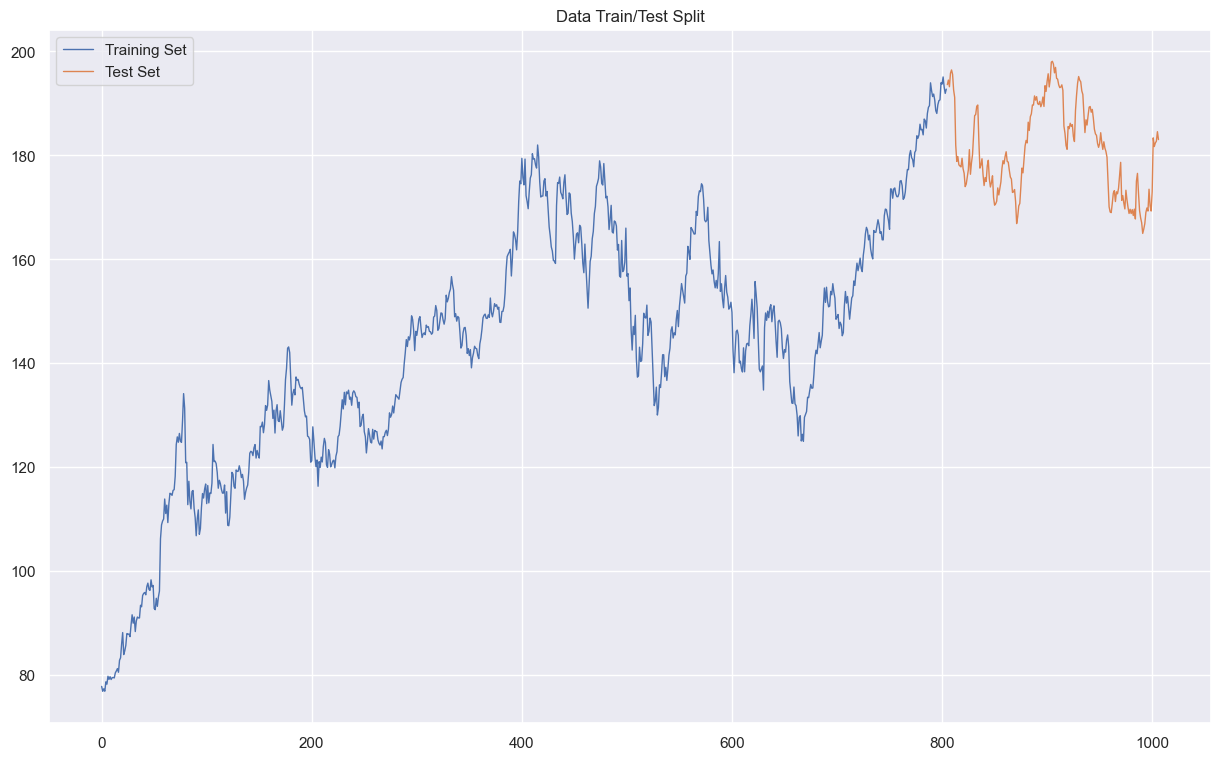

In [67]:
l = len(df)
split = 0.8
train = df[:int(split*l)]
test = df[int(split*l):]
fig , ax = plt.subplots(figsize=(15,9))
train['Close'].plot(ax= ax , label = 'Training Set' , title='Data Train/Test Split' , linewidth = 1, markersize = 5)
test['Close'].plot(ax= ax , label = 'Test Set' , linewidth = 1, markersize = 5)
# ax.axvline(pd.Timestamp(split_date),color='black',ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

In [70]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,comany_name,Daily-Max-Fluctuation,Daily-Fluctuation,Day,predictions,return,shifted_predictions,strategy_returns,ret,strat
0,2020-05-12,79.457497,79.922501,77.727501,77.852501,76.031929,162301200,Apple,2.195000,1.604996,12,1,NaN,NaN,NaN,0.000000,0.000000
1,2020-05-13,78.037498,78.987503,75.802498,76.912498,75.113914,200622400,Apple,3.185005,1.125000,13,1,-0.012074,1.0,-0.012074,-0.012074,-0.012074
2,2020-05-14,76.127502,77.447502,75.382500,77.385002,75.575363,158929200,Apple,2.065002,-1.257500,14,1,0.006143,1.0,0.006143,-0.005931,-0.005931
3,2020-05-15,75.087502,76.974998,75.052498,76.927498,75.128563,166348400,Apple,1.922501,-1.839996,15,1,-0.005912,1.0,-0.005912,-0.011843,-0.011843
4,2020-05-18,78.292503,79.125000,77.580002,78.739998,76.898674,135178400,Apple,1.544998,-0.447495,18,1,0.023561,1.0,0.023561,0.011718,0.011718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,2024-05-06,182.350006,184.199997,180.419998,181.710007,181.463882,78569700,Apple,3.779999,0.639999,6,1,-0.009107,1.0,-0.009107,1.018194,1.357562
1003,2024-05-07,183.449997,184.899994,181.320007,182.399994,182.152924,77305800,Apple,3.579987,1.050003,7,1,0.003797,1.0,0.003797,1.021991,1.361359
1004,2024-05-08,182.850006,183.070007,181.449997,182.740005,182.492477,45057100,Apple,1.620010,0.110001,8,1,0.001864,1.0,0.001864,1.023855,1.363223
1005,2024-05-09,182.559998,184.660004,182.110001,184.570007,184.320007,48983000,Apple,2.550003,-2.010010,9,1,0.010014,1.0,0.010014,1.033870,1.373237


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   1007 non-null   datetime64[ns]
 1   Open                   1007 non-null   float64       
 2   High                   1007 non-null   float64       
 3   Low                    1007 non-null   float64       
 4   Close                  1007 non-null   float64       
 5   Adj Close              1007 non-null   float64       
 6   Volume                 1007 non-null   int64         
 7   comany_name            1007 non-null   object        
 8   Daily-Max-Fluctuation  1007 non-null   float64       
 9   Daily-Fluctuation      1007 non-null   float64       
 10  Day                    1007 non-null   int32         
 11  predictions            1007 non-null   int32         
 12  return                 1006 non-null   float64       
 13  shi

In [76]:
# def plot_week_of_data(df,start_date,end_date):
#   df.loc[(df.index>start_date)&(df.index<end_date)].plot(figsize=(15,5),title='Week of Data',linewidth=1,markersize=5)
#   plt.show()
# plot_week_of_data(df,'2023-01-01','2023-01-08')

TypeError: '>' not supported between instances of 'numpy.ndarray' and 'Timestamp'

In [79]:
df.reset_index(inplace=True)
train.reset_index(inplace=True)
test.reset_index(inplace=True)

def feature_engineering(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    df['Date'] = pd.to_datetime(df['Date'])
    df['SMA_5'] = df['Close'].rolling(5).mean().shift()
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['RSI'] = rsi.fillna(0)

feature_engineering(df)
feature_engineering(train)
feature_engineering(test)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

In [80]:
import pandas as pd

# Assuming df is your DataFrame containing the dataset
# df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' column is datetime type

# Set 'Date' column as index
train.set_index('Date', inplace=True)

# Drop 'company_name' column
train.drop('comany_name', axis=1, inplace=True)

# Display DataFrame after modifications
print(train.head())

# Set 'Date' column as index
test.set_index('Date', inplace=True)

# Drop 'company_name' column
test.drop('comany_name', axis=1, inplace=True)

# Display DataFrame after modifications
print(test.head())


            index       Open       High        Low      Close  Adj Close  \
Date                                                                       
2020-05-12      0  79.457497  79.922501  77.727501  77.852501  76.031929   
2020-05-13      1  78.037498  78.987503  75.802498  76.912498  75.113914   
2020-05-14      2  76.127502  77.447502  75.382500  77.385002  75.575363   
2020-05-15      3  75.087502  76.974998  75.052498  76.927498  75.128563   
2020-05-18      4  78.292503  79.125000  77.580002  78.739998  76.898674   

               Volume  Daily-Max-Fluctuation  Daily-Fluctuation  Day  \
Date                                                                   
2020-05-12  162301200               2.195000           1.604996   12   
2020-05-13  200622400               3.185005           1.125000   13   
2020-05-14  158929200               2.065002          -1.257500   14   
2020-05-15  166348400               1.922501          -1.839996   15   
2020-05-18  135178400              

In [81]:
train_features = ['Open','High','Low','Adj Close','Volume','SMA_5','month','year','RSI']
predictor_variables = ['Close']

x_train = train[train_features]
y_train = train[predictor_variables]

x_test = test[train_features]
y_test = test[predictor_variables]

In [83]:
import xgboost as xgb
XGB = xgb.XGBRegressor(base_score = 0.5,
                       booster = 'gbtree',
                       n_estimators = 3000,
                       early_stopping_rounds=50,
                       max_depth=6,
                       learning_rate=0.01,
                       min_child_weight=1,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       gamma=0,
                       reg_alpha=0,
                       reg_lambda=1)
XGB.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],verbose=100)

[0]	validation_0-rmse:142.80193	validation_1-rmse:179.06379
[100]	validation_0-rmse:52.78626	validation_1-rmse:69.94744
[200]	validation_0-rmse:19.56278	validation_1-rmse:27.25174
[300]	validation_0-rmse:7.28359	validation_1-rmse:10.75450
[400]	validation_0-rmse:2.74828	validation_1-rmse:4.41385
[500]	validation_0-rmse:1.09304	validation_1-rmse:2.11115
[600]	validation_0-rmse:0.50702	validation_1-rmse:1.37540
[700]	validation_0-rmse:0.31518	validation_1-rmse:1.20369
[800]	validation_0-rmse:0.25391	validation_1-rmse:1.14322
[900]	validation_0-rmse:0.22476	validation_1-rmse:1.11177
[1000]	validation_0-rmse:0.20336	validation_1-rmse:1.09469
[1100]	validation_0-rmse:0.18408	validation_1-rmse:1.08886
[1200]	validation_0-rmse:0.16680	validation_1-rmse:1.08418
[1300]	validation_0-rmse:0.15041	validation_1-rmse:1.08250
[1342]	validation_0-rmse:0.14478	validation_1-rmse:1.08285


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

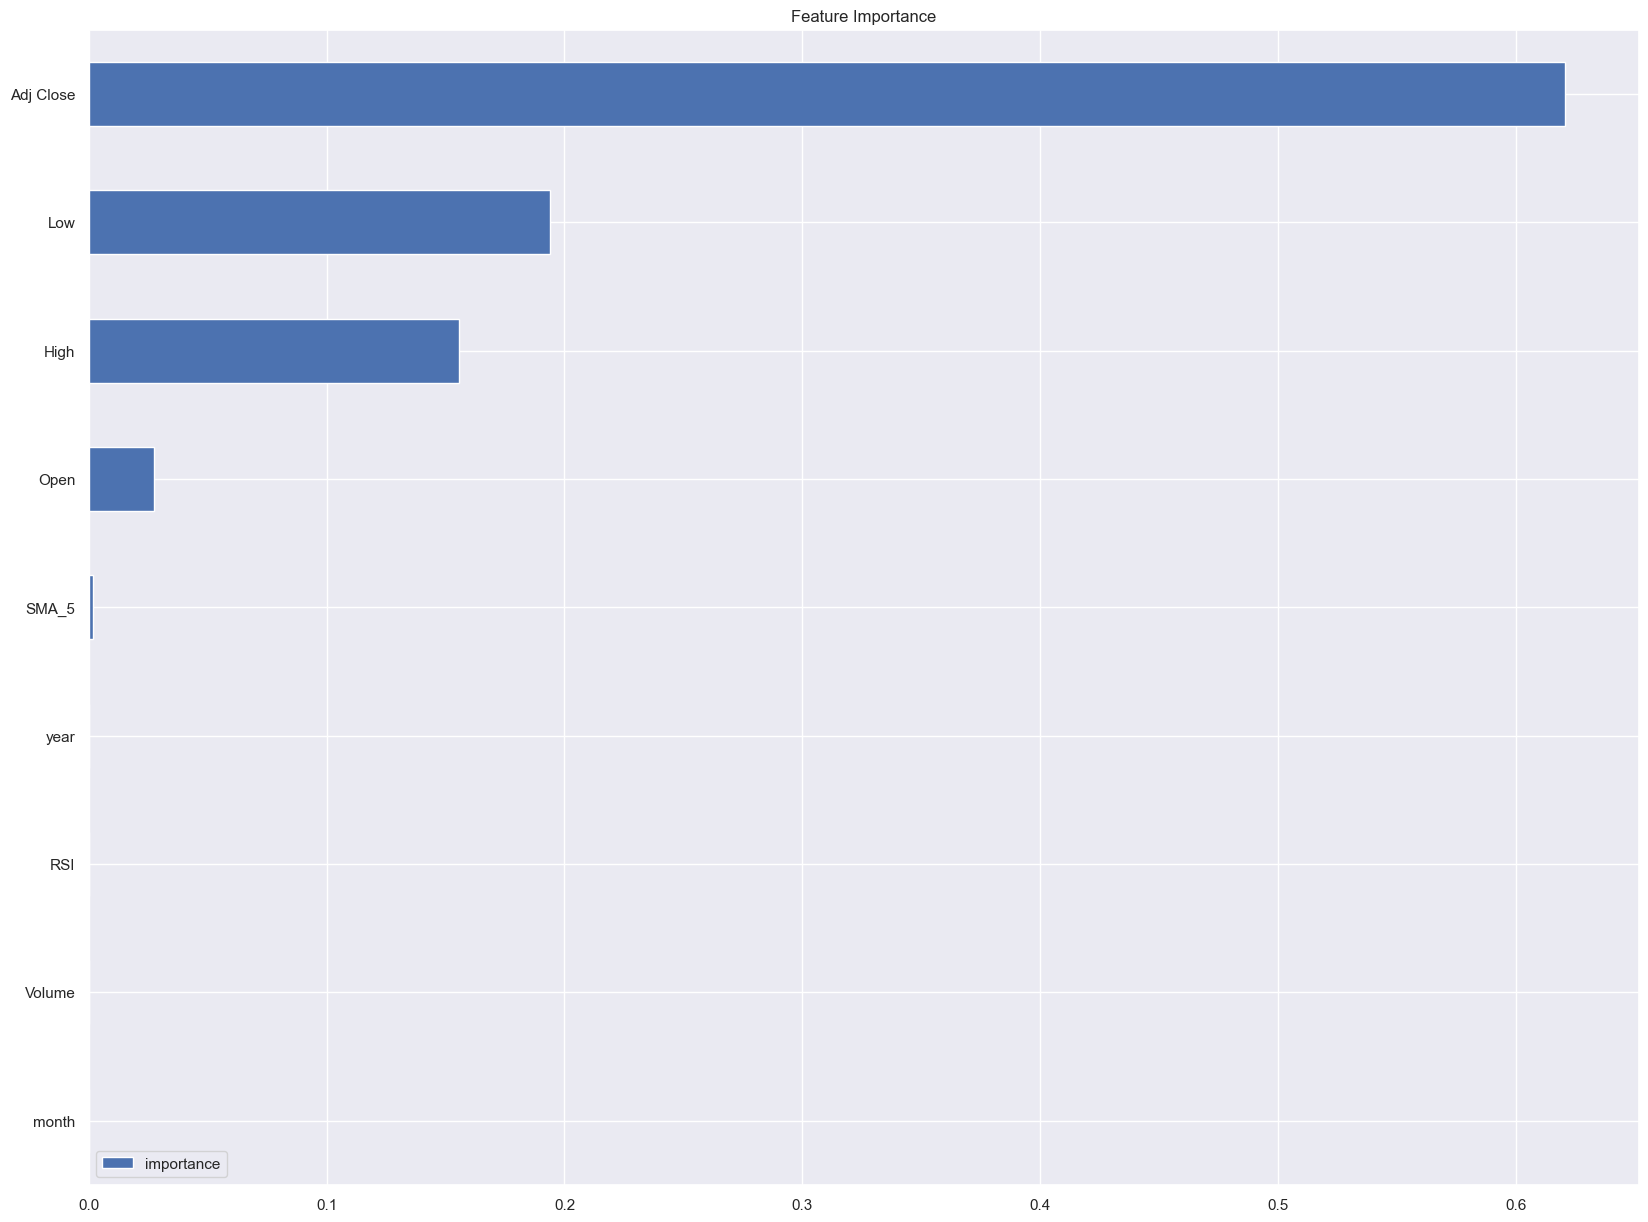

In [84]:
F_Score_Plot = pd.DataFrame(data = XGB.feature_importances_,index = XGB.feature_names_in_,columns=['importance'])
F_Score_Plot.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()

In [87]:
predictions

array([193.53029, 193.01294, 193.01294, 193.01294, 193.02817, 193.13402,
       192.40111, 191.09885, 184.12294, 179.76506, 179.75735, 179.38045,
       179.21591, 178.88321, 179.11473, 177.59013, 176.99751, 174.92172,
       174.81535, 174.91846, 177.5225 , 180.79008, 177.07889, 178.98683,
       179.18161, 181.956  , 186.70892, 187.52673, 188.87059, 188.88826,
       184.89247, 178.48631, 179.97255, 179.67517, 177.02827, 175.01607,
       175.19208, 175.19289, 179.10661, 179.59496, 175.45793, 174.4536 ,
       174.96481, 174.98892, 172.53107, 170.9476 , 170.87889, 171.80962,
       174.13913, 172.53168, 174.14166, 174.8735 , 177.20569, 178.8144 ,
       179.21097, 179.10019, 180.76901, 179.2406 , 179.14484, 177.82318,
       175.60344, 175.6033 , 173.95941, 173.41728, 173.76775, 171.7734 ,
       166.73862, 169.09825, 170.31946, 170.73322, 174.15823, 178.21175,
       176.55315, 179.02692, 181.0404 , 181.20222, 183.06985, 185.38832,
       185.3199 , 187.8291 , 188.43857, 189.36644, 

In [85]:
predictions = XGB.predict(x_test)
test['predictions'] = predictions
df = df.merge(test[['predictions']],how='left',left_index=True,right_index=True)
df.tail(2)

,index,Date,Open,High,Low,Close,Adj Close,Volume,comany_name,Daily-Max-Fluctuation,...,return,shifted_predictions,strategy_returns,ret,strat,SMA_5,month,year,RSI,predictions_y
1005,1005,2024-05-09,182.559998,184.660004,182.110001,184.570007,184.320007,48983000,Apple,2.550003,...,0.010014,1.0,0.010014,1.033870,1.373237,180.652002,5,2024,80.116979,NaN
1006,1006,2024-05-10,184.899994,185.089996,182.130005,183.050003,183.050003,50727400,Apple,2.959991,...,-0.008235,1.0,-0.008235,1.025634,1.365002,182.960004,5,2024,75.942128,NaN


In [92]:
df['predictions_y'].tolist()

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

KeyError: 'predictions'

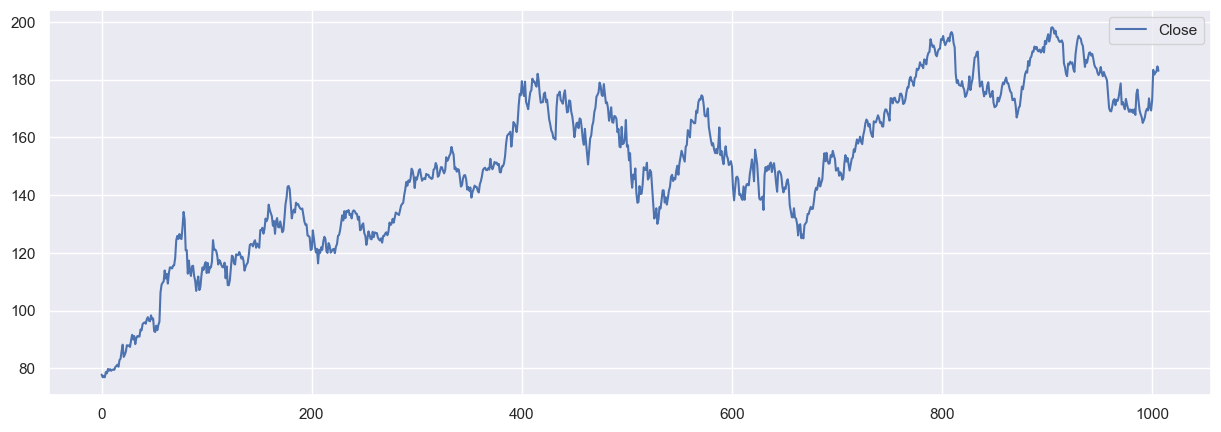

In [86]:
ax = df[['Close']].plot(figsize=(15,5))

df['predictions'].plot(ax=ax,style='.')

plt.legend(["Actual Prices","XGBoost Predictions"])
ax.set_title('Actual Past Data vs Predictions')
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(test['Close'],test['predictions']))
print(score)

5.354084283773934


In [ ]:
forecast['abs_error'] = np.abs(forecast['yhat'] - apple_stocks_temp_test['y'])

# Calculate mean error per day
mean_error_per_day = forecast['abs_error'].mean()

print("Mean error per day:", mean_error_per_day," USD")

Mean error per day: 8.869661113144598  USD


In [ ]:
apple_stocks

,level_0,index,Date,Open,High,Low,Close,Adj Close,Volume,comany_name
0,0,0,2014-05-12,20.981787,21.202143,20.978571,21.172501,18.727831,213208800,Apple
1,1,1,2014-05-13,21.142857,21.233570,21.096430,21.205713,18.757204,159737200,Apple
2,2,2,2014-05-14,21.158215,21.335714,21.133572,21.209642,18.760679,166404000,Apple
3,3,3,2014-05-15,21.239286,21.307142,21.001429,21.029285,18.601147,230846000,Apple
4,4,4,2014-05-16,21.022499,21.340357,20.907143,21.339643,18.875662,276256400,Apple
...,...,...,...,...,...,...,...,...,...,...
2513,2513,2513,2024-05-06,182.350006,184.199997,180.419998,181.710007,181.463882,78569700,Apple
2514,2514,2514,2024-05-07,183.449997,184.899994,181.320007,182.399994,182.152924,77305800,Apple
2515,2515,2515,2024-05-08,182.850006,183.070007,181.449997,182.740005,182.492477,45057100,Apple
2516,2516,2516,2024-05-09,182.559998,184.660004,182.110001,184.570007,184.320007,48983000,Apple


In [ ]:
apple_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2518 non-null   datetime64[ns]
 1   level_0      2518 non-null   int64         
 2   index        2518 non-null   int64         
 3   Open         2518 non-null   float64       
 4   High         2518 non-null   float64       
 5   Low          2518 non-null   float64       
 6   Close        2518 non-null   float64       
 7   Adj Close    2518 non-null   float64       
 8   Volume       2518 non-null   int64         
 9   comany_name  2518 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 196.8+ KB


In [ ]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(apple_stocks, model='additive')
fig = decomposition.plot()
plt.show()

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [ ]:
!pip install scikit-learn xgboost

In [ ]:
temp = apple_stocks[['Close']].copy()
temp.head()

,Close
0,21.172501
1,21.205713
2,21.209642
3,21.029285
4,21.339643
